In [1]:
#importing of key modules

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import scikitplot as skplt

In [2]:
#reads in data from csv as long as the csv is in the same folder as the notebook
data = pd.read_csv('cardio-vascular-data.csv')

allDataDF = pd.DataFrame(data)

In [3]:
#there are entries with no label, removing before use
allDataDF = allDataDF.loc[(allDataDF['label']  == 'Risk') | (allDataDF['label']  == 'NoRisk')]

## Data Cleaning/Preprocessing

In [4]:
#remove entry with empty string value for contralateral lesions
allDataDF['Contra'] = allDataDF['Contra'].astype(str).str.extract(pat='(\d+)', expand=False)
allDataDF['Contra'] = allDataDF['Contra'].astype(float)

#replacing null cerebral lesion values with mean
allDataDF['IPSI'].fillna(allDataDF['IPSI'].mean(), inplace = True)
allDataDF['Contra'].fillna(allDataDF['Contra'].mean(), inplace = True)

#removing entries with cerebral lesion outliers (3 standard deviations or more away from the mean)
allDataDF = allDataDF[allDataDF['IPSI'] >= (allDataDF['IPSI'].mean() - 3*allDataDF['IPSI'].std())]
allDataDF = allDataDF[allDataDF['IPSI'] <= (allDataDF['IPSI'].mean() + 3*allDataDF['IPSI'].std())]
 
allDataDF = allDataDF[allDataDF['Contra'] >= (allDataDF['Contra'].mean() - 3*allDataDF['Contra'].std())]
allDataDF = allDataDF[allDataDF['Contra'] <= (allDataDF['Contra'].mean() + 3*allDataDF['Contra'].std())]

#doing this at the top of the notebook because this removal affects the creation of dummies for the other indicators/conditions

# Confusion Matrices for Indications

In [5]:
#generating dummies for each indication which caused the hospitalisation
#Asymptomatic Stenosis is labelled as both 'Asx' and 'ASx' in the data, making all entries of 'Asx'
#into entries of 'ASx' for consistency
allDataDF['Indication'] = allDataDF['Indication'].replace(to_replace='Asx', value='ASx')

indicationDummies = pd.get_dummies(allDataDF['Indication'])

atFibDF = indicationDummies['A-F']
asymStenDF = indicationDummies['ASx']
cardArrestDF = indicationDummies['CVA']
transIschAttack = indicationDummies['TIA']

labelDummies = pd.get_dummies(allDataDF['label'])

groundTruth = labelDummies['Risk']

#plot confusion matrices for each of the different indicators that hospitalised the patient to see which have
#the most considerable effect on risk

## Atrial Fibrillation

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

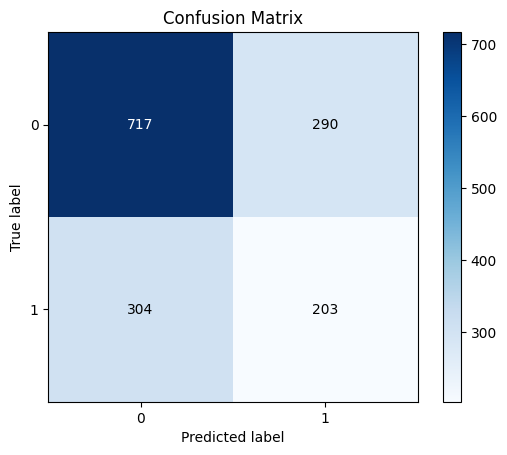

In [6]:
skplt.metrics.plot_confusion_matrix(groundTruth, indicationDummies['A-F'], normalize = False)

## Asymptomatic Stenosis

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

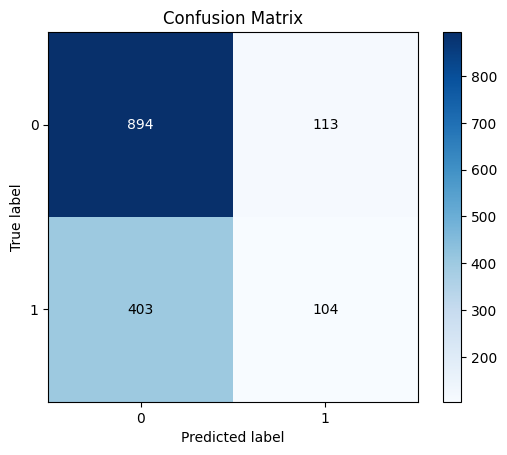

In [7]:
skplt.metrics.plot_confusion_matrix(groundTruth, indicationDummies['ASx'], normalize = False)

## Cardiovascular Arrest

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

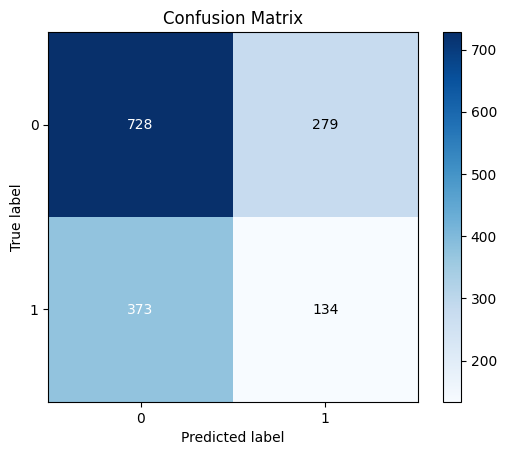

In [8]:
skplt.metrics.plot_confusion_matrix(groundTruth, indicationDummies['CVA'], normalize = False)

## Transient Ischemic Attack

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

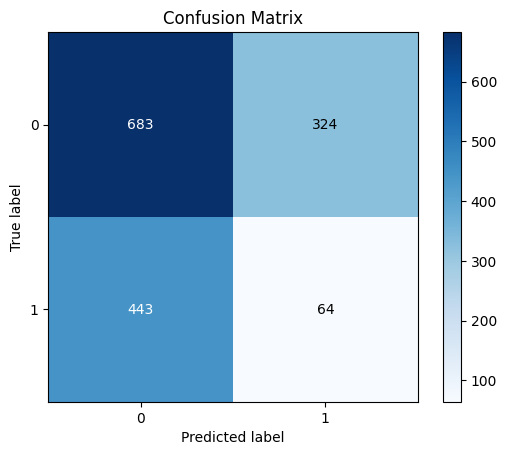

In [9]:
skplt.metrics.plot_confusion_matrix(groundTruth, indicationDummies['TIA'], normalize = False)

# Confusion Matrices for patient conditions/history

In [10]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

#plot confusion matrices of the other conditions the patients had or didn't have upon hospitalisation
diabetesDummies = pd.get_dummies(allDataDF['Diabetes'])
ihdDummies = pd.get_dummies(allDataDF['IHD'])
hypertensionDummies = pd.get_dummies(allDataDF['Hypertension'])
arrhythmiaDummies = pd.get_dummies(allDataDF['Arrhythmia'])
historyDummies = pd.get_dummies(allDataDF['History'])

diabetesDummies = diabetesDummies['yes']
ihdDummies = ihdDummies['yes']
hypertensionDummies = hypertensionDummies['yes']
arrhythmiaDummies = arrhythmiaDummies['yes']
historyDummies = historyDummies['yes']

#plot confusion matrices for each of the conditions the patient could have in the data had upon hospitalisation

## Diabetes

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

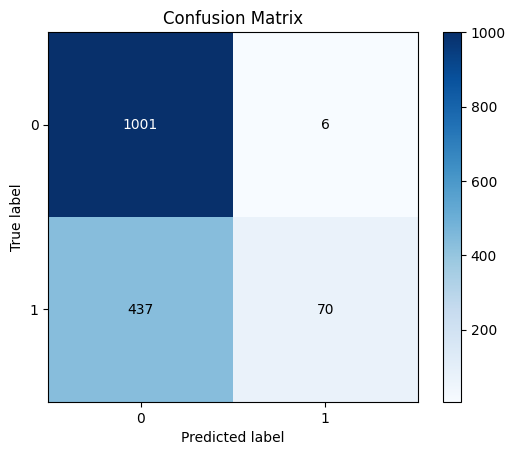

In [11]:
skplt.metrics.plot_confusion_matrix(groundTruth, diabetesDummies, normalize = False)

## IHD

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

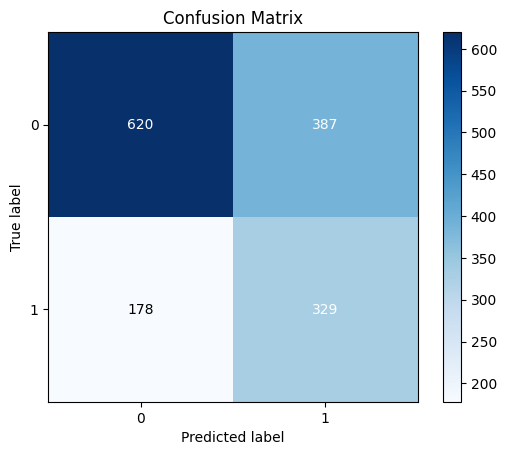

In [12]:
skplt.metrics.plot_confusion_matrix(groundTruth, ihdDummies, normalize = False)

## Hypertension

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

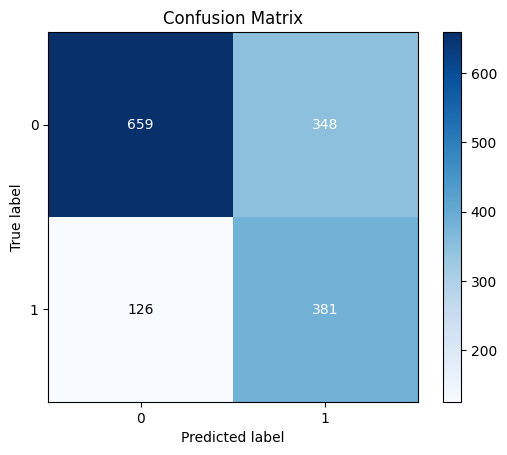

In [13]:
skplt.metrics.plot_confusion_matrix(groundTruth, hypertensionDummies, normalize = False)

## Arrhythmia

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

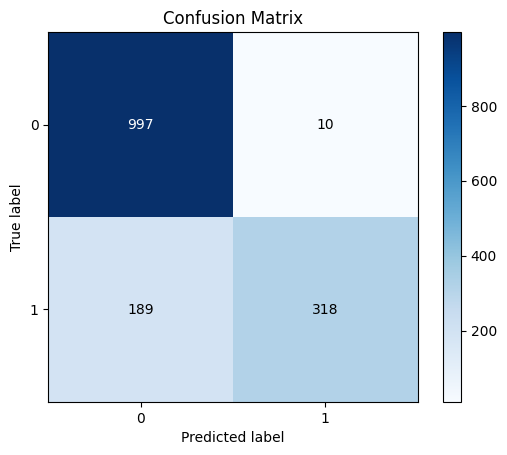

In [14]:
skplt.metrics.plot_confusion_matrix(groundTruth, arrhythmiaDummies, normalize = False)

## History

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

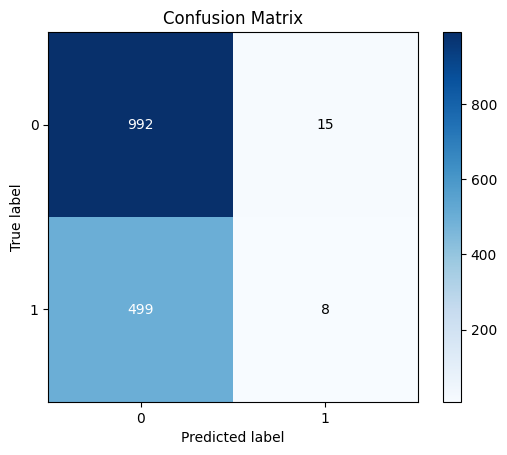

In [15]:
skplt.metrics.plot_confusion_matrix(groundTruth, historyDummies, normalize = False)

## Average rate of risk for all entries

In [16]:
groundTruth.value_counts()

0    1007
1     507
Name: Risk, dtype: int64

# Plotting of Cerebral Ischemic Lesions against Risk

In [17]:
lesionDF = pd.DataFrame({
    'IPSI': allDataDF['IPSI'],
    'Contra': allDataDF['Contra'],
    'label': groundTruth
    })

## Ipsilateral Cerebral Ischemic Lesions

<AxesSubplot: xlabel='label', ylabel='IPSI'>

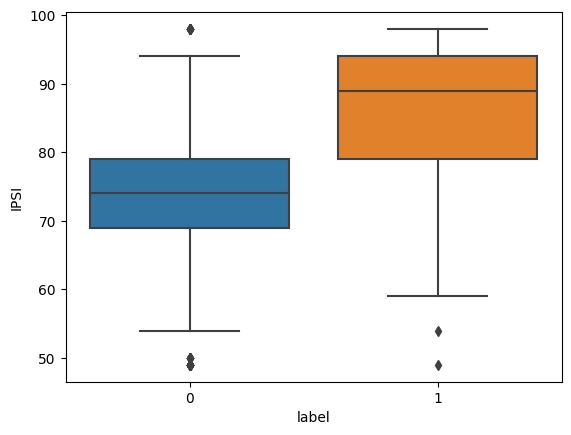

In [18]:
sns.boxplot(lesionDF,x='label',y='IPSI')

## Contralateral Cerebral Ischemic Lesions

<AxesSubplot: xlabel='label', ylabel='Contra'>

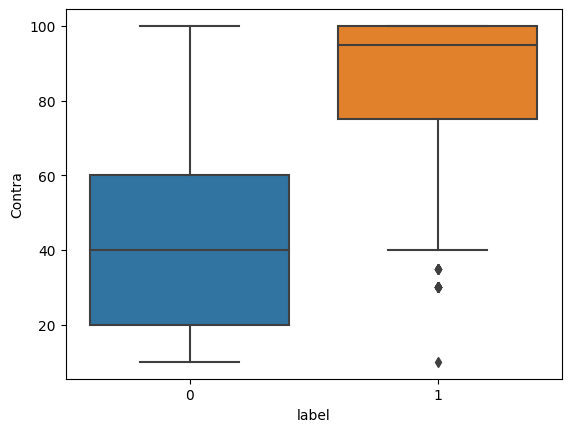

In [19]:
sns.boxplot(lesionDF,x='label',y='Contra')

## Correlation between types of lesions

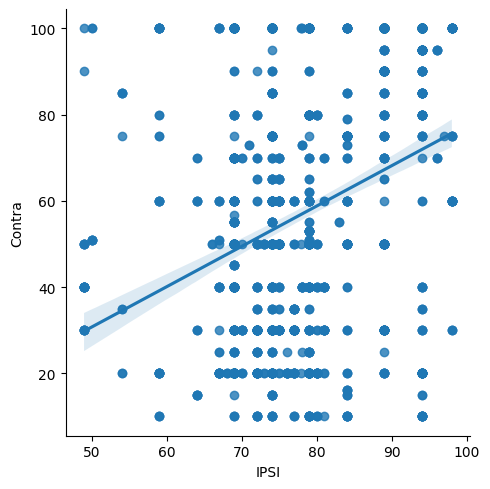

In [20]:
sns.lmplot(lesionDF,x='IPSI',y='Contra')

# Data Modification before Modelling

In [21]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

##combines the dummies for all the indications and conditions with the data for contralateral
##and ipsilateral cerebral ischemic lesions

dataForModel = pd.concat({'atrial fibrillation': atFibDF,
                         'asymptomatic stenosis': asymStenDF,
                         'cardiac arrest': cardArrestDF,
                         'transient ischemic attack': transIschAttack,
                         'diabetes': diabetesDummies,
                         'IHD': ihdDummies,
                         'hypertension': hypertensionDummies,
                         'arrhythmia': arrhythmiaDummies,
                         'history': historyDummies,
                         'contralateral lesions': allDataDF['Contra'],
                         'ipsilateral lesions': allDataDF['IPSI']}, axis = 1)

print(dataForModel['ipsilateral lesions'])

#x = data that is not risk, y = risk
x, y = dataForModel, allDataDF['label']

0       89.0
1       67.0
2       79.0
3       69.0
4       89.0
        ... 
1515    74.0
1516    84.0
1517    76.0
1518    75.0
1519    81.0
Name: ipsilateral lesions, Length: 1514, dtype: float64


# Decision Tree Modelling

0.9714285714285714
0.9530201342281879


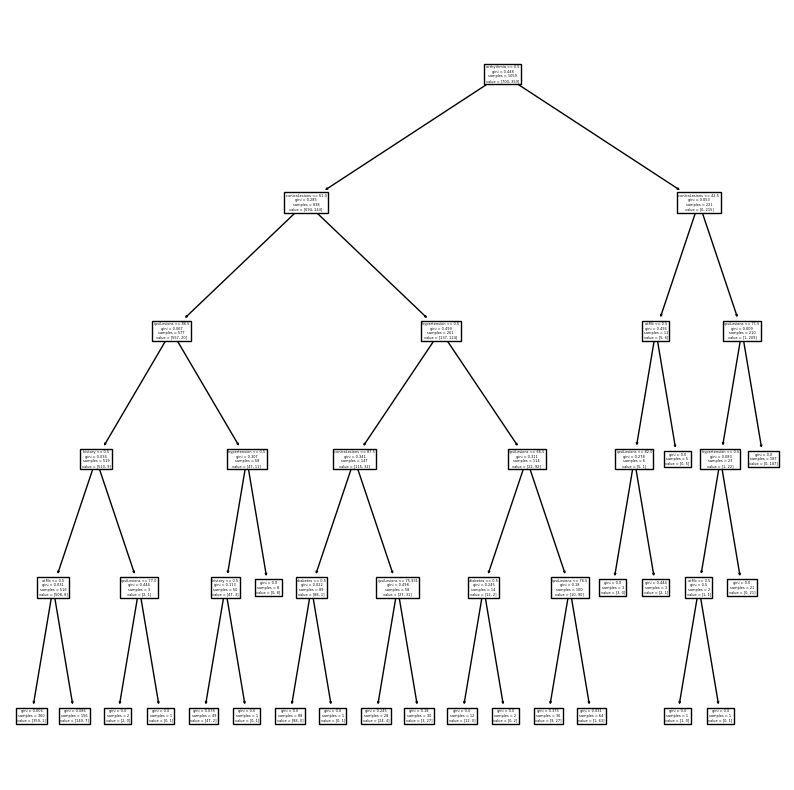

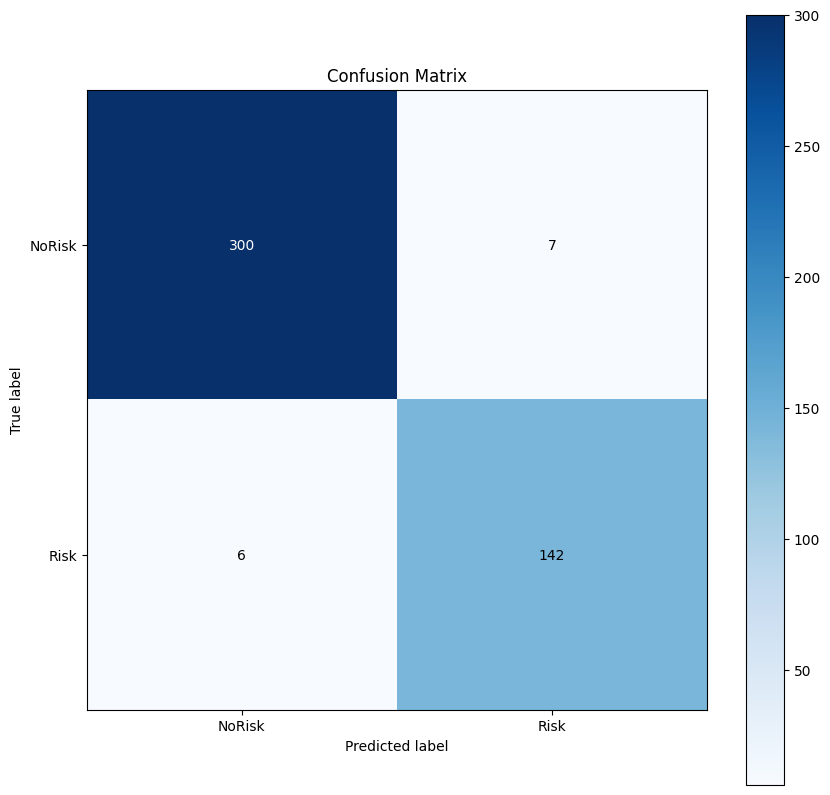

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle=True)
model = DecisionTreeClassifier(max_depth = 5)
treemodel = model.fit(X = x_train, y = y_train)

#size of items on the tree plot
plt.rcParams['figure.figsize'] = (10,10)
plot_tree(model, feature_names=('atFib','asymSten','cardArrest','transIschAttack','diabetes','IHD','hypertension','arrhythmia','history','contraLesions','ipsiLesions'),
         max_depth = 5)

pred_y = treemodel.predict(x_test).ravel()
skplt.metrics.plot_confusion_matrix(y_test, pred_y)

#accuracy and precision scores
print(accuracy_score(y_test, pred_y, normalize=True))
print(precision_score(y_test, pred_y, pos_label = 'Risk'))

# MLP Modelling

0.9824175824175824
0.967948717948718


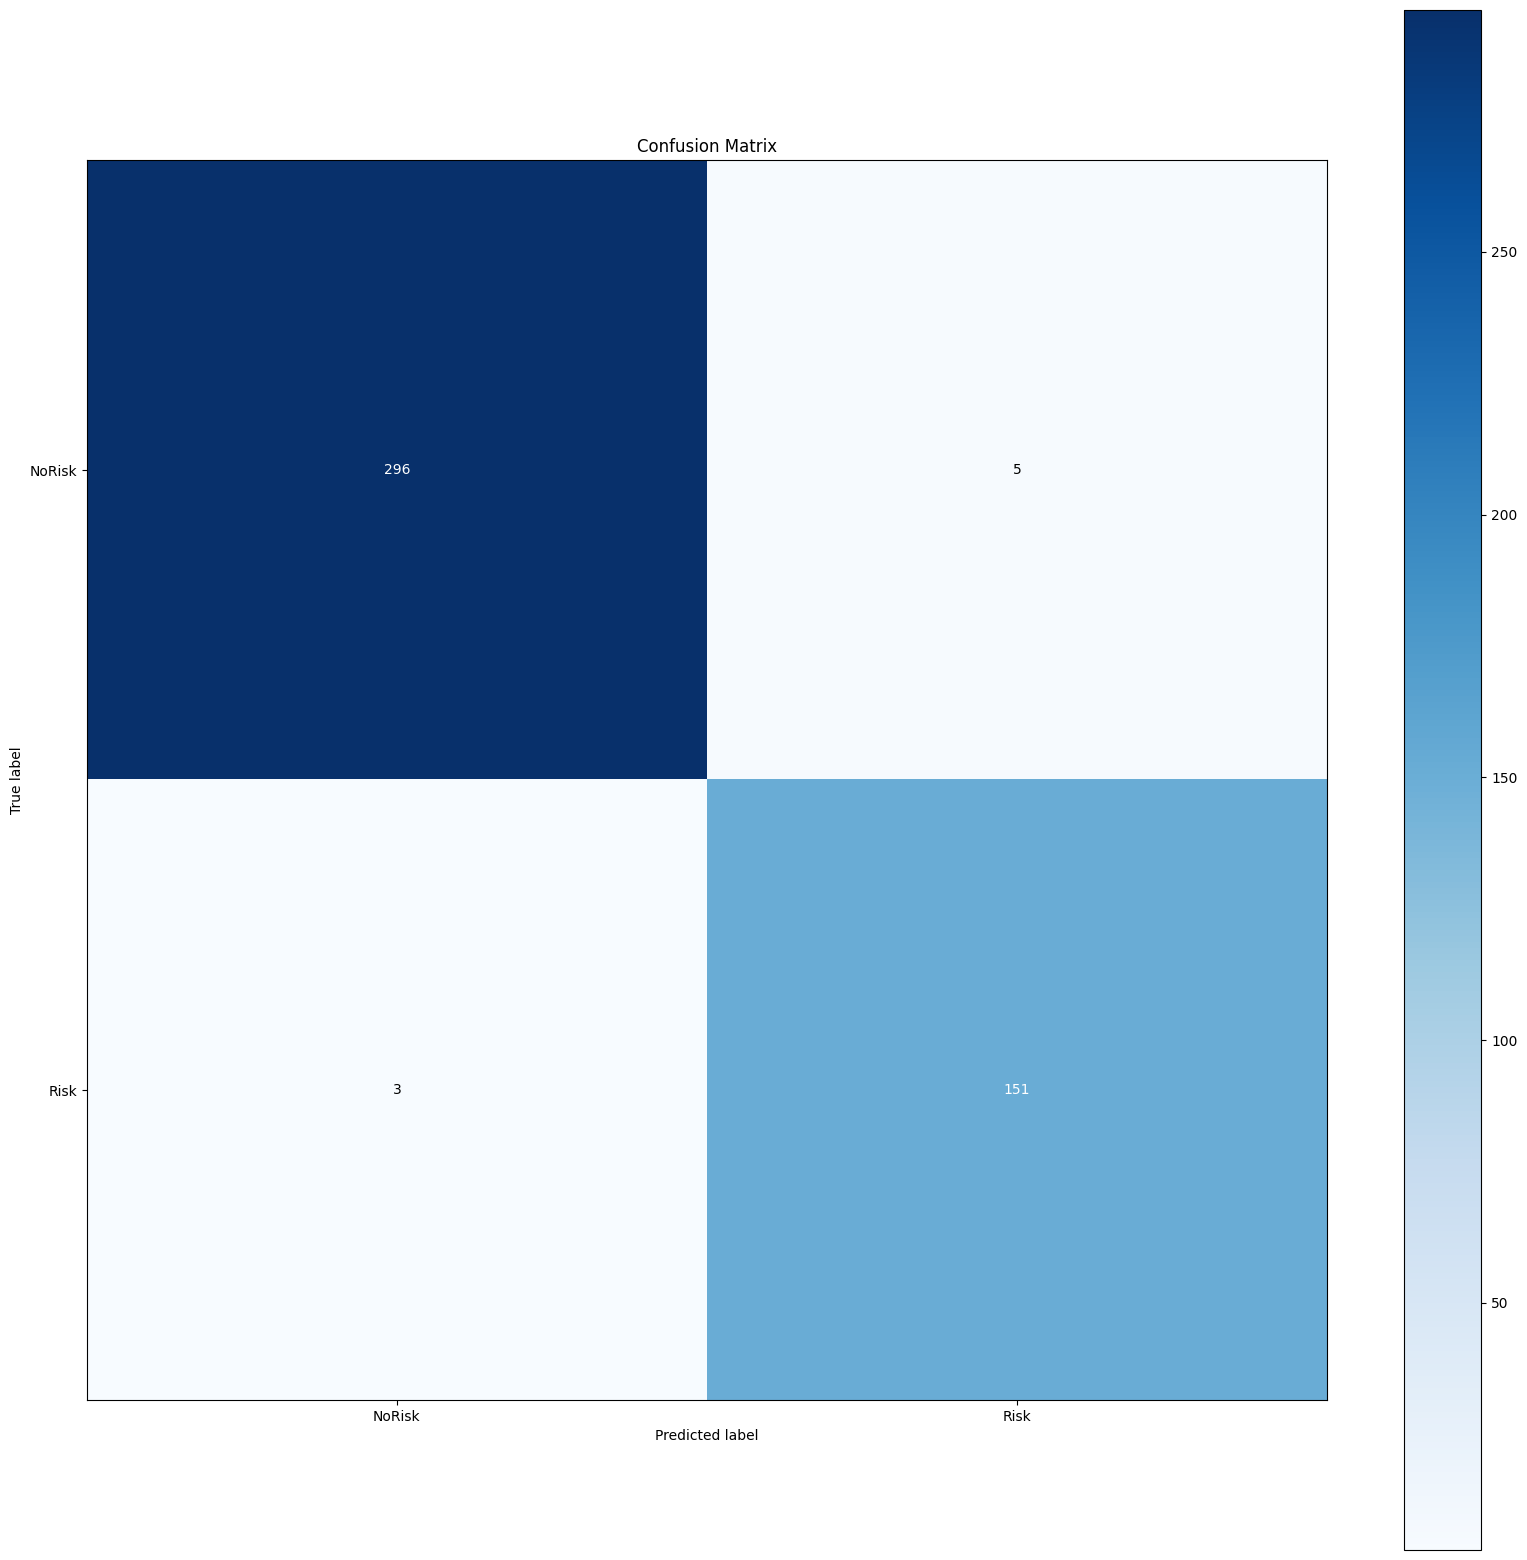

In [23]:
from sklearn.neural_network import MLPClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle=True)

#solver options: lbfgs, adam, sgd
#activation options: logistic, identity, tanh, relu
model = MLPClassifier(solver = 'lbfgs', activation = 'logistic', max_iter= 20000, hidden_layer_sizes = 500).fit(x_train, y_train)
pred_y = model.predict(x_test).ravel() 
skplt.metrics.plot_confusion_matrix(y_test, pred_y, normalize = False)

print(accuracy_score(y_test, pred_y, normalize=True))
print(precision_score(y_test, pred_y, pos_label = 'Risk'))

# Random Forest Modelling

0.9934065934065934
0.9872611464968153


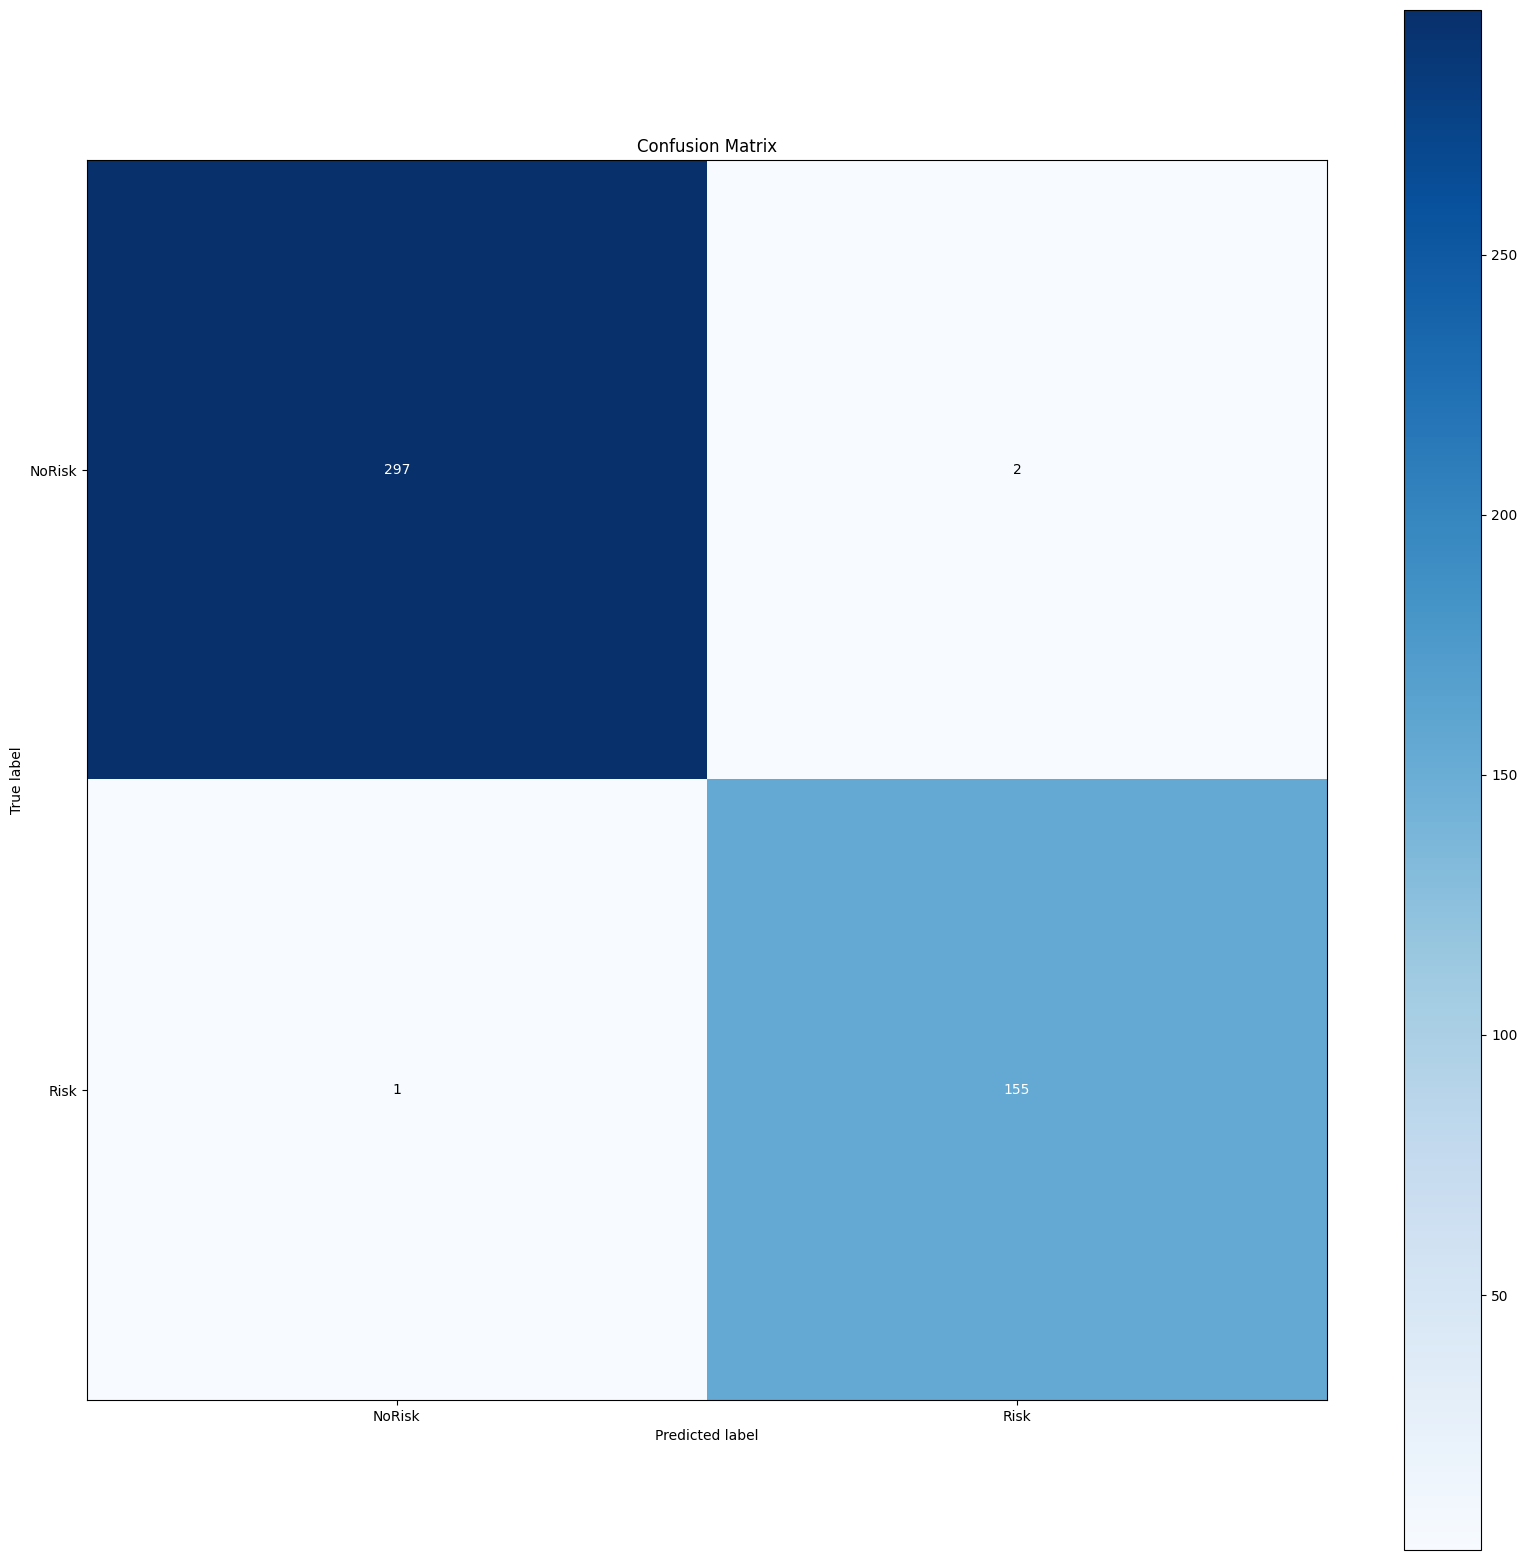

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle=True)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, max_depth = None)
rf.fit( x_train, y_train)
pred_y = rf.predict(x_test).ravel() 
skplt.metrics.plot_confusion_matrix(y_test, pred_y, normalize = False)

print(accuracy_score(y_test, pred_y, normalize=True))
print(precision_score(y_test, pred_y, pos_label = 'Risk'))